In [1]:

import pandas as pd
import numpy as np
from sklearn.utils import resample

df = pd.read_csv("../model_trainning/csv/ET1_K62_K63_K64.csv")

grade_to_gpa = {
    'A+': 4.0, 'A': 4.0,
    'B+': 3.5, 'B': 3.0,
    'C+': 2.5, 'C': 2.0,
    'D+': 1.5, 'D': 1.0,
    'F': 0.0
}
df = df[df['Final Grade'].isin(grade_to_gpa)]
df['GPA'] = df['Final Grade'].map(grade_to_gpa)
df['Weighted GPA'] = df['GPA'] * pd.to_numeric(df['Credits'], errors='coerce')

for col in ['Credits', 'Continuous Assessment Score', 'Exam Score']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Credits', 'Continuous Assessment Score', 'Exam Score'])

semester_gpa = (
    df.groupby(['student_id', 'Semester'])
    .apply(lambda x: x['Weighted GPA'].sum() / x['Credits'].sum())
    .reset_index(name='SemesterGPA')
)

df_full = df.merge(semester_gpa, on=["student_id", "Semester"], how="left")

summary = (
    df_full.groupby(['student_id', 'Semester'])
    .agg({
        'Credits': 'sum',
        'Continuous Assessment Score': 'mean',
        'Exam Score': 'mean',
        'GPA': 'mean',
        'Weighted GPA': 'sum',
        'SemesterGPA': 'first'
    })
    .reset_index()
    .sort_values(by=['student_id', 'Semester'])
)
# Take N semesers data to predict the N+k semester GPA
N = 3
k = 2
X, y = [], []
# Features: [total semester credits, avg midterm, avg final, semester GPA, CPA] x N semesters 
feature_cols = ['Credits', 'Continuous Assessment Score', 'Exam Score', 'GPA', 'Weighted GPA']
for _, group in summary.groupby('student_id'):
    values = group[feature_cols + ['SemesterGPA']].values
    if len(values) > N + k - 1:
        for i in range(len(values) - (N + k - 1)):
            feat = values[i:i+N, :-1].flatten()
            target = values[i+N+k-1, -1]
            if not np.isnan(feat).any() and not np.isnan(target):
                X.append(feat)
                y.append(target)

data = pd.DataFrame(X, columns=[f"{f}_T{i+1}" for i in range(N) for f in feature_cols])
data['target'] = y

low_gpa = data[data['target'] < 1.5]
high_gpa = data[data['target'] >= 1.5]
low_upsampled = resample(low_gpa, replace=True, n_samples=len(high_gpa), random_state=42)
balanced_data = pd.concat([high_gpa, low_upsampled])

# balanced_data.to_csv(f'balanced_gpa_training_data_{N}.csv', index=False)
# print("Save file done")


C:\Users\datth\AppData\Local\Temp\ipykernel_3956\936850444.py:24: RuntimeWarning: invalid value encountered in scalar divide
  .apply(lambda x: x['Weighted GPA'].sum() / x['Credits'].sum())
C:\Users\datth\AppData\Local\Temp\ipykernel_3956\936850444.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['Weighted GPA'].sum() / x['Credits'].sum())


In [2]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Load preprocessed GPA sequence data
data = balanced_data.copy()
X = data.drop('target', axis=1).values
y = data['target'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Balanced Random Forest MSE: {mse:.4f}")


Balanced Random Forest MSE: 0.2717


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# In các chỉ số đánh giá
print("\n===== CÁC CHỈ SỐ ĐÁNH GIÁ MÔ HÌNH =====")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² (R-squared): {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")


===== CÁC CHỈ SỐ ĐÁNH GIÁ MÔ HÌNH =====
MSE (Mean Squared Error): 0.2717
RMSE (Root Mean Squared Error): 0.5213
MAE (Mean Absolute Error): 0.2997
R² (R-squared): 0.8343
Explained Variance Score: 0.8454


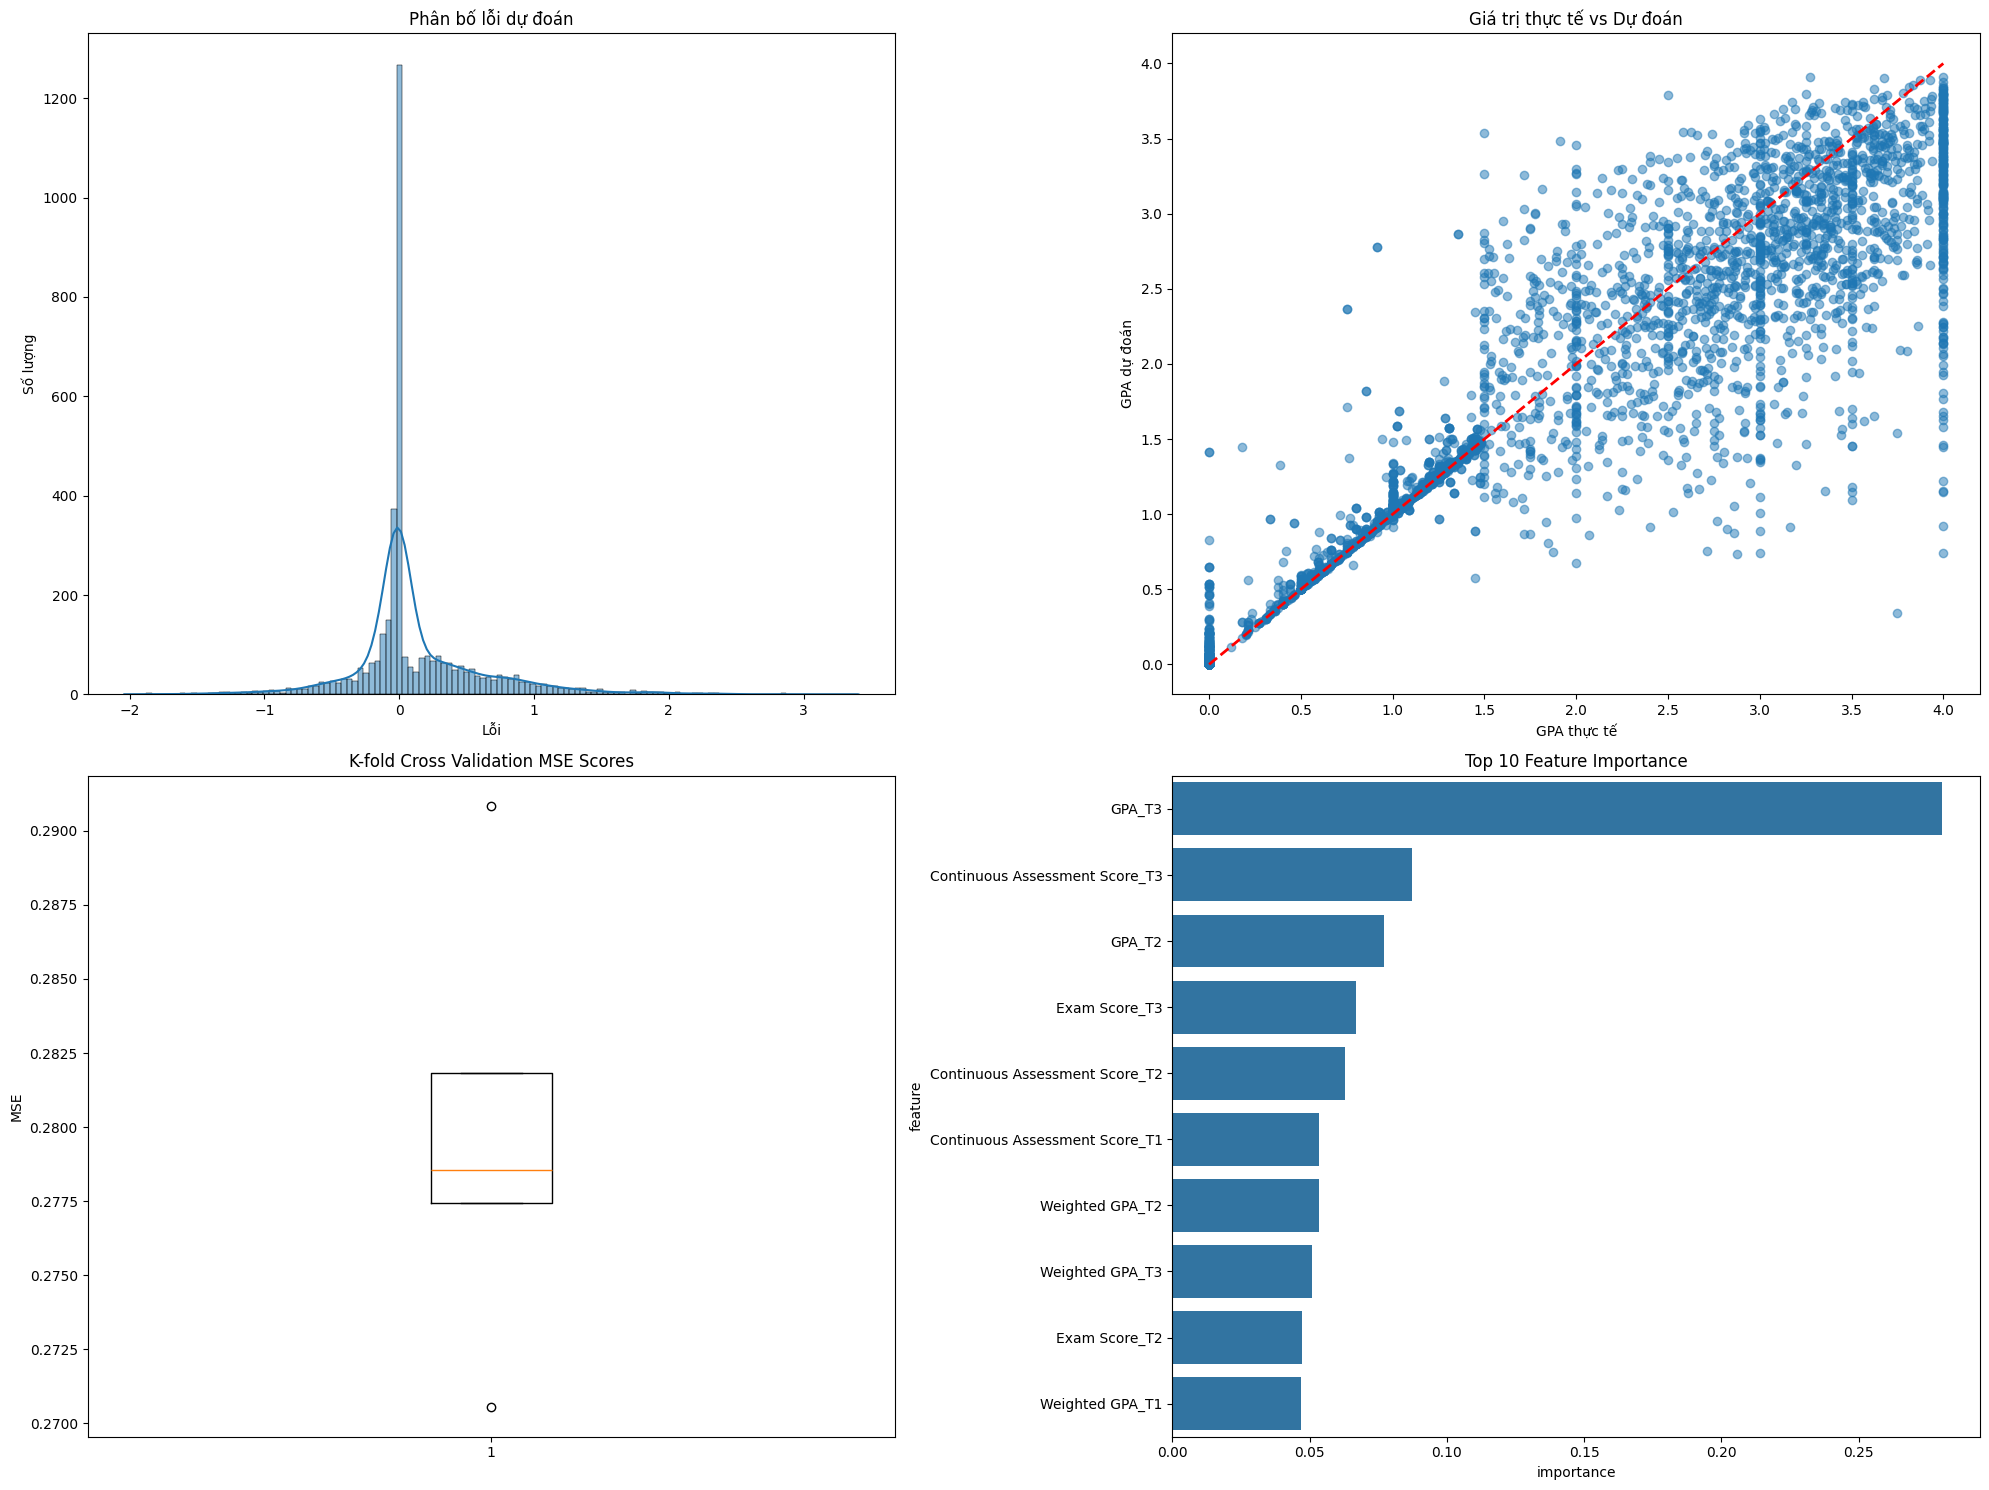


K-fold Cross Validation Results:
Mean MSE: 0.2798
Std MSE: 0.0066


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

# Thiết lập style cho đồ thị
# plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))

# 1. Phân bố lỗi dự đoán
plt.subplot(2, 2, 1)
errors = y_test - y_pred
sns.histplot(errors, kde=True)
plt.title('Phân bố lỗi dự đoán')
plt.xlabel('Lỗi')
plt.ylabel('Số lượng')

# 2. Scatter plot giữa giá trị thực tế và dự đoán
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Giá trị thực tế vs Dự đoán')
plt.xlabel('GPA thực tế')
plt.ylabel('GPA dự đoán')

# 3. K-fold Cross Validation
plt.subplot(2, 2, 3)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
plt.boxplot(mse_scores)
plt.title('K-fold Cross Validation MSE Scores')
plt.ylabel('MSE')

# 4. Feature Importance
plt.subplot(2, 2, 4)
feature_importance = pd.DataFrame({
    'feature': data.drop('target', axis=1).columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 10 Feature Importance')

plt.tight_layout()
plt.show()

# In thống kê về K-fold Cross Validation
print(f"\nK-fold Cross Validation Results:")
print(f"Mean MSE: {mse_scores.mean():.4f}")
print(f"Std MSE: {mse_scores.std():.4f}")